In [14]:
import numpy as np 
from numpy import random as npr
import matplotlib.pyplot as plt
import seaborn as sns


In [79]:
def sigmoid(z, coef = -1):
    return((1 + np.exp(coef*z))**(-1))

def ReLU(Z):
    return np.maximum(Z, 0)

def cross_entropy(y, p):
    return -sum(y*np.log(p) + (1-y)*np.log(1-p))

def pFromX(X, seed = 123):
    npr.seed(seed)
    T = X @ npr.randn(D, 8)/1.5
    T += .3*sigmoid(T) + .5*sigmoid(T, 1)
    T -= np.exp(T/5)
    T -= np.tile(T.mean(0), T.shape[0]).reshape(T.shape)
    T /= np.tile(T.std(0), T.shape[0]).reshape(T.shape)/(10)
    p = sigmoid(T.mean(1) - T.mean())
    return p

def generate_data(N, D, pFromX, seed = 123):
    npr.seed(seed)
    mu = npr.randn(D) # means
    Sigma = np.eye(D) # covariance
    X = npr.multivariate_normal(mu, Sigma, size = N) # get data (X)
    latent_p = pFromX(X) # get latent P
    y = npr.binomial(1, latent_p, N).reshape(N, 1) # true outcome values
    return X, y


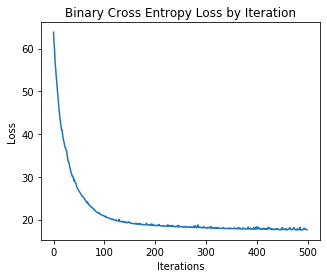

In [142]:
class NN():
    
    def __init__(self, name = None):
        self.name = name
      
    def add_data(self, X, y):
        self.N, self.D = X.shape
        self.X = X
        self.y = y
        
    def forward_pass(self):
        for layer in range(self.layers):
            if layer == 0: self.Z[layer] = (self.X @ self.W[layer]) + self.B[layer]
            else: self.Z[layer] = (self.A[layer - 1] @ self.W[layer]) + self.B[layer]
            self.A[layer] = self.activations[layer](self.Z[layer]) 
    
    def forward_pass_batch(self, batch):
        
        # data
        self.Xb = self.X[batch]
        self.yb = self.y[batch]
        
        # intermediate stuff
        for layer in range(self.layers):
            if layer == 0: self.Zb[layer] = (self.Xb @ self.W[layer]) + self.B[layer]
            if layer !=0: self.Zb[layer] = (self.Ab[layer-1] @ self.W[layer]) + self.B[layer]
            self.Ab[layer] = self.activations[layer](self.Zb[layer])
        # update probs in original 
        self.A[-1][batch] = self.Ab[-1]
        
    def get_derivatives(self, batch):
        
        # update batch
        self.forward_pass_batch(batch)

        # do last one 
        self.Wmom[-1] = self.dLdW[-1]
        self.Bmom[-1] = self.dLdB[-1]        
        self.dLdA[-1] = (-self.yb/self.Ab[-1] + (1-self.yb)/(1-self.Ab[-1])) # (B, 1)
        self.dLdZ[-1] = (self.dLdA[-1] * sigmoid(self.Zb[-1])*(1-sigmoid(self.Zb[-1]))) # (B, 1)
        self.dLdB[-1] = (self.dLdZ[-1].sum(0)) # 1
        self.dLdW[-1] = ((self.dLdZ[-1].T @ self.Ab[-1]).T) # (h, 1)
        
        # do the rest and do them in reverse
        for layer in range(self.layers-1)[::-1]:

            # change old derivatives to momentum terms 
            self.Wmom[layer] = self.dLdW[layer]
            self.Bmom[layer] = self.dLdB[layer]

            # get derivatives of loss function
            self.dLdA[layer] = self.dLdZ[layer + 1] @ self.W[layer + 1].T 
            self.dLdZ[layer] = self.dLdA[layer] * (self.Zb[layer] > 0) 
            self.dLdB[layer] = self.dLdZ[layer].sum(0)
            if layer == 0: self.dLdW[layer] = (self.dLdZ[layer].T @ self.Xb).T
            else: self.dLdW[layer] = (self.dLdZ[layer].T @ self.Ab[layer-1]).T 

    def update_parameters(self):
        for layer in range(self.layers):
            self.W[layer] -= (self.lr*self.dLdW[layer] + self.momentum*self.Wmom[layer])
            self.B[layer] -= (self.lr*self.dLdB[layer] + self.momentum*self.Bmom[layer])
    
    def track_loss(self):
        self.L = cross_entropy(self.y, self.A[-1])[0]
            
    def instantiate(self):
        self.W = []
        self.B = []
        self.Z = [None for i in range(self.layers)]
        self.A = [None for i in range(self.layers)]
        self.Zb = [None for i in range(self.layers)]
        self.Ab = [None for i in range(self.layers)]
        self.dLdW = []
        self.dLdB = []
        self.dLdZ = [None for i in range(self.layers)]
        self.dLdA = [None for i in range(self.layers)]
        self.Wmom = [None for i in range(self.layers)]
        self.Bmom = [None for i in range(self.layers)]
        
        for layer in range(self.layers):
            
            # get layer and previous layer
            current_h = self.h[layer]
            prev_h = self.prev_h[layer]
            
            # generate random W and B 
            self.W.append(npr.randn(prev_h*current_h).reshape((prev_h, current_h)))
            self.B.append(npr.randn(current_h))

            # derivatives/momentum (set to 0 so the first momentum terms are 0)
            self.dLdW.append(np.zeros((prev_h, current_h)))
            self.dLdB.append(np.zeros(current_h))
    
    def build(self, h, activations):
        self.prev_h = [self.D] + list(h)
        self.h = list(h) + [1]
        self.layers = len(self.h)
        self.activations = activations

    def train(self, lr, epochs, batch_size, momentum = 0):
        # add parameters
        self.lr = lr
        self.epochs = epochs 
        self.batch_size = batch_size
        self.momentum = momentum
        
        # instantiate and fill in initial A and Z 
        self.instantiate()
        self.forward_pass()

        # train by epoch
        self.losses = []
        n_batches = self.N // self.batch_size
        for epoch in range(epochs):
            batch_indices = np.split(npr.permutation(np.arange(self.N)), n_batches)
            for i, batch in enumerate(batch_indices):
                self.get_derivatives(batch)
                self.update_parameters()
            self.forward_pass()
            self.track_loss()
            self.losses.append(self.L)
        self.yhat = self.A[-1]
        
    def predict(self, Xtest = None):
        if Xtest is None:
            Xtest = self.X
        self.Xtest = Xtest
        self.Ztest = [None for i in range(self.layers)]
        self.Atest = [None for i in range(self.layers)]
        
        for layer in range(self.layers):
            if layer == 0: self.Ztest[layer] = (self.Xtest @ self.W[layer]) + self.B[layer]
            else: self.Ztest[layer] = (self.Atest[layer-1] @ self.W[layer]) + self.B[layer]
            self.Atest[layer] = self.activations[layer](self.Ztest[layer])
        self.yhattest = self.Atest[-1]
        return(self.yhattest) 
    
    def get_loss(self, X = None, y = None):
        if (X is None) or (y is None):
            return cross_entropy(self.y, self.yhat)[0]
        else:
            yhat = self.predict(X)
            return cross_entropy(y, yhat)[0]
        
    def plot_losses(self):
        fig, ax = plt.subplots(figsize = (5, 4))
        sns.lineplot(np.arange(self.epochs), self.losses)
        ax.set(xlabel = 'Iterations', ylabel = 'Loss', title = 'Binary Cross Entropy Loss by Iteration');
        
    def plot_ps(self):
        fig, ax = plt.subplots(figsize = (5, 4))
        sns.scatterplot(self.latent_p, self.A[-1].reshape(-1))
        sns.lineplot(np.arange(2), np.arange(2))
        ax.set(xlabel = 'latent p', ylabel = 'p');

N, D = 100, 4
X, y = generate_data(N, D, pFromX, seed = 123)
Xtest, ytest = generate_data(N, D, pFromX, seed = 124)
hidden_layers, activations = [4, 4], [ReLU, ReLU, sigmoid]
lr, epochs, batch_size, momentum = 0.001, 500, 10, 0.001

nn = NN()
nn.add_data(X, y)
nn.build(hidden_layers, activations)
nn.train(lr, epochs, batch_size, momentum)
nn.plot_losses()


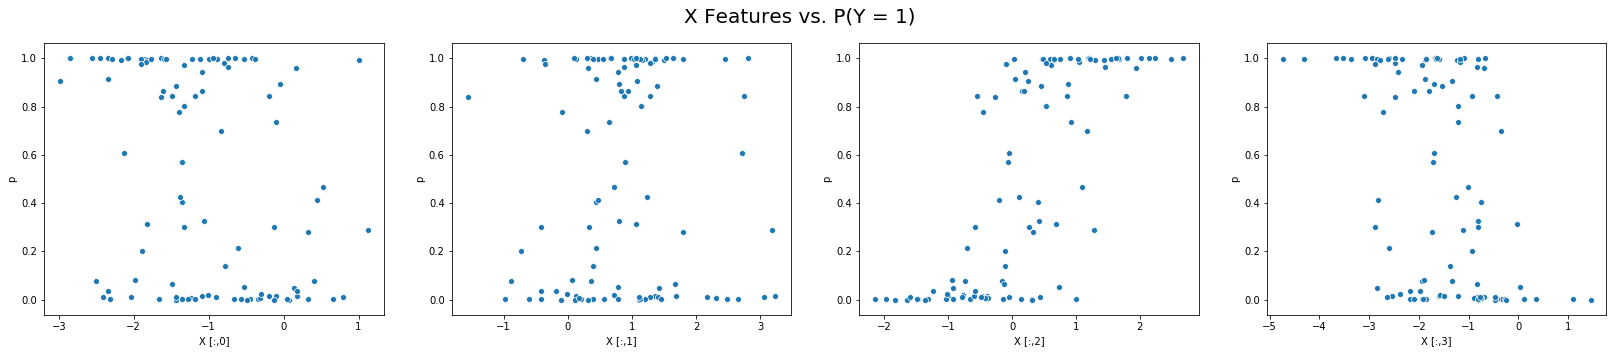

In [143]:
fig, ax = plt.subplots(1, D, figsize = (7*D, 5))
for i in range(D):
    sns.scatterplot(X[:,i], pFromX(X), ax = ax[i])
    ax[i].set(xlabel = f'X [:,{i}]', ylabel = 'p')
fig.suptitle('X Features vs. P(Y = 1)', fontsize = 20);

In [144]:
from sklearn.linear_model import LogisticRegression as LR
lr = LR(C = 0.1)
lr.fit(nn.X, nn.y.reshape(-1))
yhat_lr = lr.predict_proba(X)[:,1]
yhattest_lr = lr.predict_proba(Xtest)[:,1]

In [145]:
print('Cross entropy for...\n')
print('Logistic in-sample:', round(cross_entropy(y.reshape(-1), yhat_lr),3))
print('Neural Net in-sample:', round(nn.get_loss(X, y), 3))
print('')
print('Logistic out-of-sample:', round(cross_entropy(ytest.reshape(-1), yhattest_lr),3))
print('Neural Net out-of-sample:', round(nn.get_loss(Xtest, ytest), 3))


Cross entropy for...

Logistic in-sample: 35.176
Neural Net in-sample: 17.642

Logistic out-of-sample: 154.085
Neural Net out-of-sample: 113.172
